# 01 — EDA & Preprocessing

This notebook loads the **ISOT Fake News Dataset**, performs exploratory data analysis (EDA) to understand the data's structure and patterns, then applies a full text-preprocessing pipeline and saves the result to `data/processed/cleaned_isot.csv`.

**Outline**
1. Load & label data  
2. EDA — distributions, word frequencies, word clouds, topic breakdowns  
3. Preprocessing pipeline  
4. Save cleaned data  

In [1]:
import os, re, string, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

# NLTK resources
for r in ['punkt', 'punkt_tab', 'stopwords']:
    try:
        nltk.data.find(f'tokenizers/{r}' if 'punkt' in r else f'corpora/{r}')
    except LookupError:
        nltk.download(r, quiet=True)

print('Libraries loaded.')

Libraries loaded.


---
## 1. Load & Label Data

We load `True.csv` (label **1** = real) and `Fake.csv` (label **0** = fake), concatenate them, and create a combined `title_text` column by joining the article title and body.

In [2]:
RAW_DIR = '../data/raw'

true_df = pd.read_csv(os.path.join(RAW_DIR, 'True.csv'))
fake_df = pd.read_csv(os.path.join(RAW_DIR, 'Fake.csv'))

true_df['class'] = 1  # real
fake_df['class'] = 0  # fake

df = pd.concat([true_df, fake_df], ignore_index=True)
df['title_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

print(f'Total articles : {len(df):,}')
print(f'Real           : {(df["class"]==1).sum():,}')
print(f'Fake           : {(df["class"]==0).sum():,}')
df.head(3)

Total articles : 44,898
Real           : 21,417
Fake           : 23,481


,title,text,subject,date,class,title_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...


In [3]:
print('Missing values per column:')
print(df.isnull().sum())
print(f'\nDuplicate rows: {df.duplicated().sum()}')

Missing values per column:
title         0
text          0
subject       0
date          0
class         0
title_text    0
dtype: int64

Duplicate rows: 209


---
## 2. Exploratory Data Analysis

We explore the dataset from multiple angles: class balance, article length, vocabulary, and subject-topic distribution.

### 2a. Class Distribution

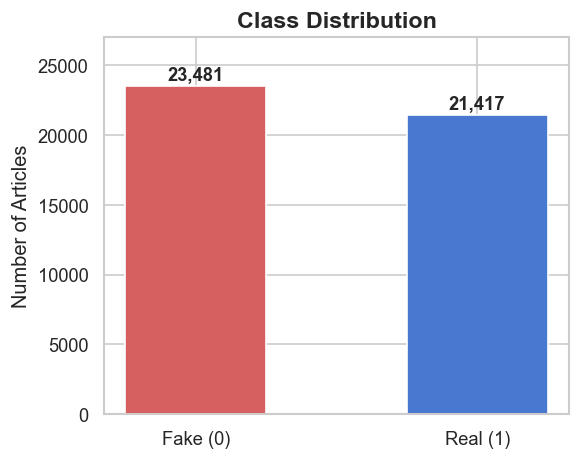

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))
counts = df['class'].value_counts().sort_index()
bars = ax.bar(['Fake (0)', 'Real (1)'], counts.values,
              color=[sns.color_palette('muted')[3], sns.color_palette('muted')[0]],
              width=0.5, edgecolor='white')
for bar, count in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 150,
            f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Articles')
ax.set_ylim(0, max(counts.values) * 1.15)
plt.tight_layout()
plt.show()

### 2b. Article Length Distribution by Class

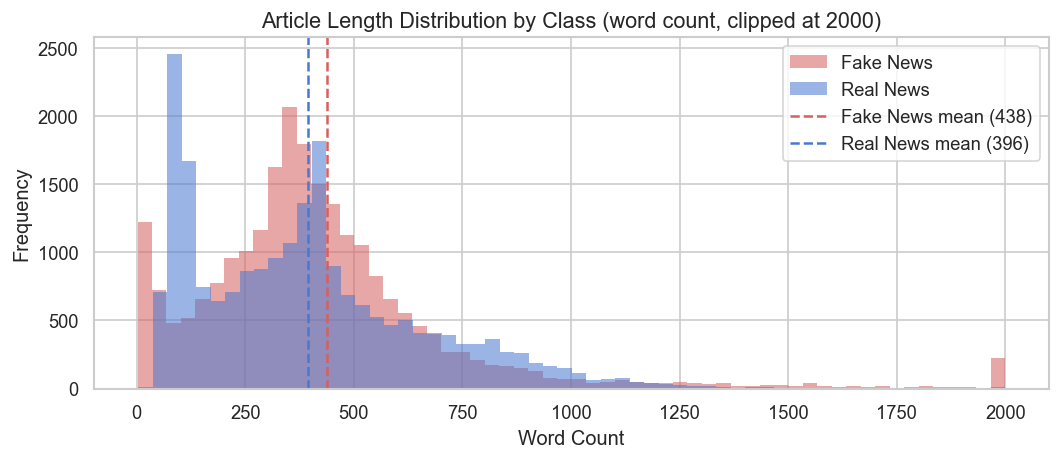

class             0             1
count  23481.000000  21417.000000
mean     437.930710    395.594574
std      408.555516    273.948006
min        2.000000      4.000000
25%      254.000000    159.000000
50%      378.000000    369.000000
75%      521.000000    534.000000
max     8148.000000   5181.000000


In [5]:
df['word_count'] = df['title_text'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(9, 4))
colors = {0: sns.color_palette('muted')[3], 1: sns.color_palette('muted')[0]}
labels = {0: 'Fake News', 1: 'Real News'}
for cls in [0, 1]:
    subset = df[df['class'] == cls]['word_count'].clip(upper=2000)
    ax.hist(subset, bins=60, alpha=0.55, color=colors[cls], label=labels[cls], edgecolor='none')

for cls in [0, 1]:
    mean_wc = df[df['class'] == cls]['word_count'].mean()
    ax.axvline(mean_wc, color=colors[cls], linestyle='--', linewidth=1.5,
               label=f'{labels[cls]} mean ({mean_wc:.0f})')

ax.set_title('Article Length Distribution by Class (word count, clipped at 2000)', fontsize=13)
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

print(df.groupby('class')['word_count'].describe().T)

### 2c. Top 20 Most Common Words per Class (excluding stopwords)

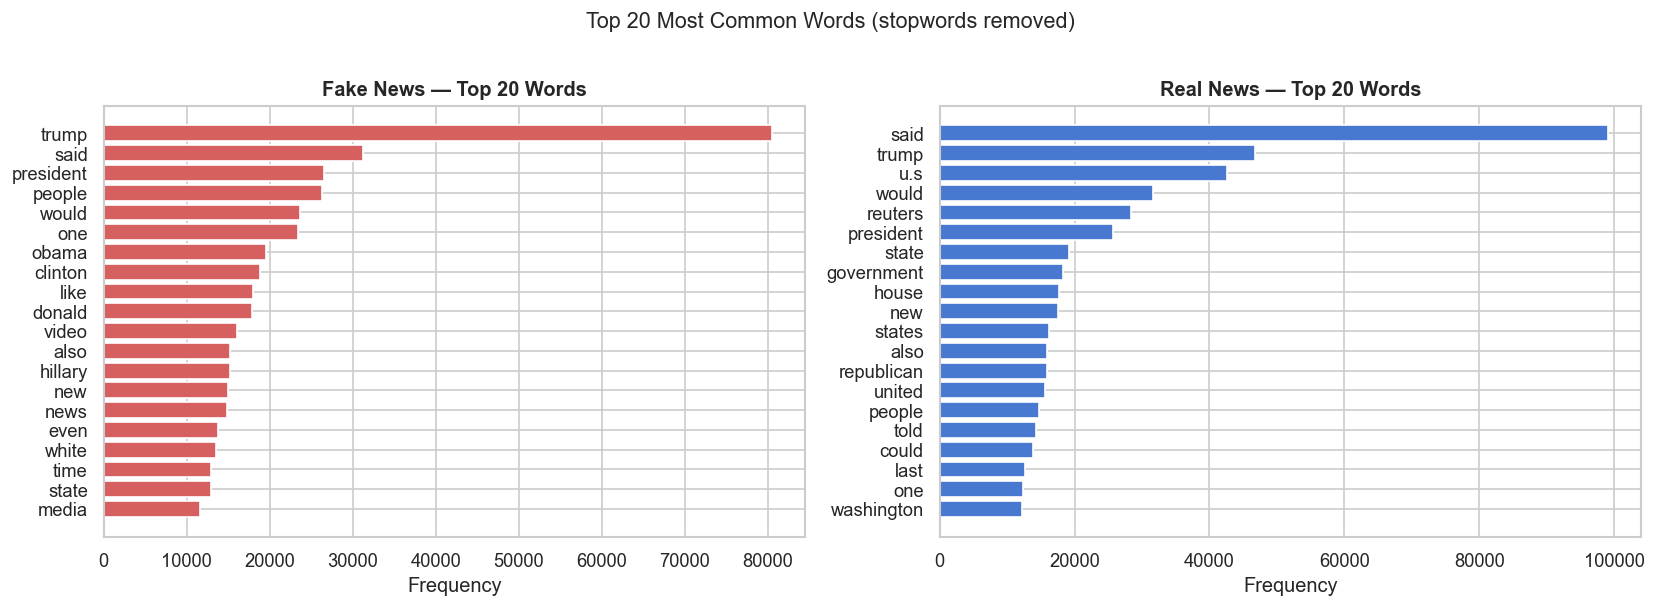

In [6]:
STOP = set(stopwords.words('english'))

def top_words(series, n=20):
    words = []
    for text in series:
        tokens = str(text).lower().split()
        words.extend([t.strip(string.punctuation) for t in tokens
                      if t.strip(string.punctuation) not in STOP
                      and len(t.strip(string.punctuation)) > 2])
    return Counter(words).most_common(n)

fake_top = top_words(df[df['class']==0]['title_text'])
real_top = top_words(df[df['class']==1]['title_text'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, top, title, color in zip(
        axes,
        [fake_top, real_top],
        ['Fake News — Top 20 Words', 'Real News — Top 20 Words'],
        [sns.color_palette('muted')[3], sns.color_palette('muted')[0]]):
    words, counts = zip(*top)
    ax.barh(list(reversed(words)), list(reversed(counts)), color=color, edgecolor='white')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Frequency')
plt.suptitle('Top 20 Most Common Words (stopwords removed)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

### 2d. Word Clouds — Fake vs. Real News

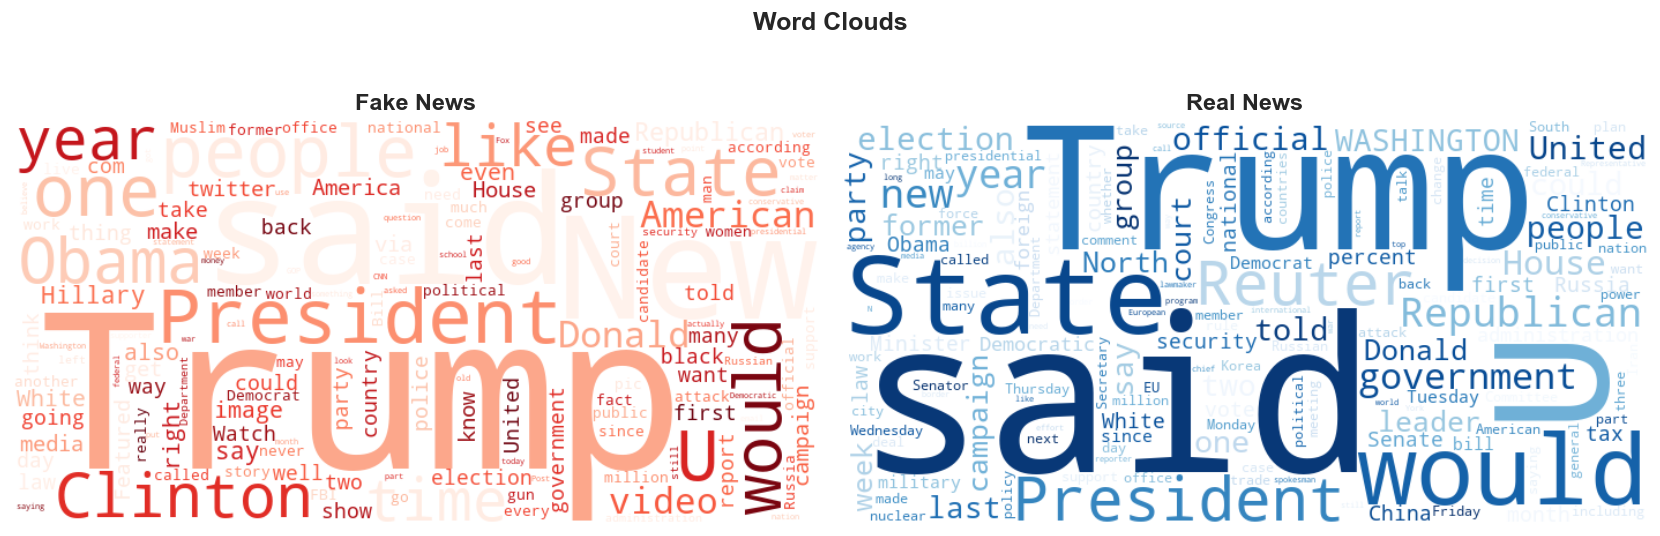

In [7]:
def make_wc(series, stopwords_set, colormap):
    text = ' '.join(series.fillna('').tolist())
    return WordCloud(
        width=700, height=350,
        background_color='white',
        stopwords=stopwords_set,
        max_words=150,
        colormap=colormap,
        collocations=False
    ).generate(text)

wc_fake = make_wc(df[df['class']==0]['title_text'], STOP, 'Reds')
wc_real = make_wc(df[df['class']==1]['title_text'], STOP, 'Blues')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.imshow(wc_fake, interpolation='bilinear'); ax1.axis('off'); ax1.set_title('Fake News', fontsize=14, fontweight='bold')
ax2.imshow(wc_real, interpolation='bilinear'); ax2.axis('off'); ax2.set_title('Real News', fontsize=14, fontweight='bold')
plt.suptitle('Word Clouds', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

### 2e. Subject/Topic Distribution by Class

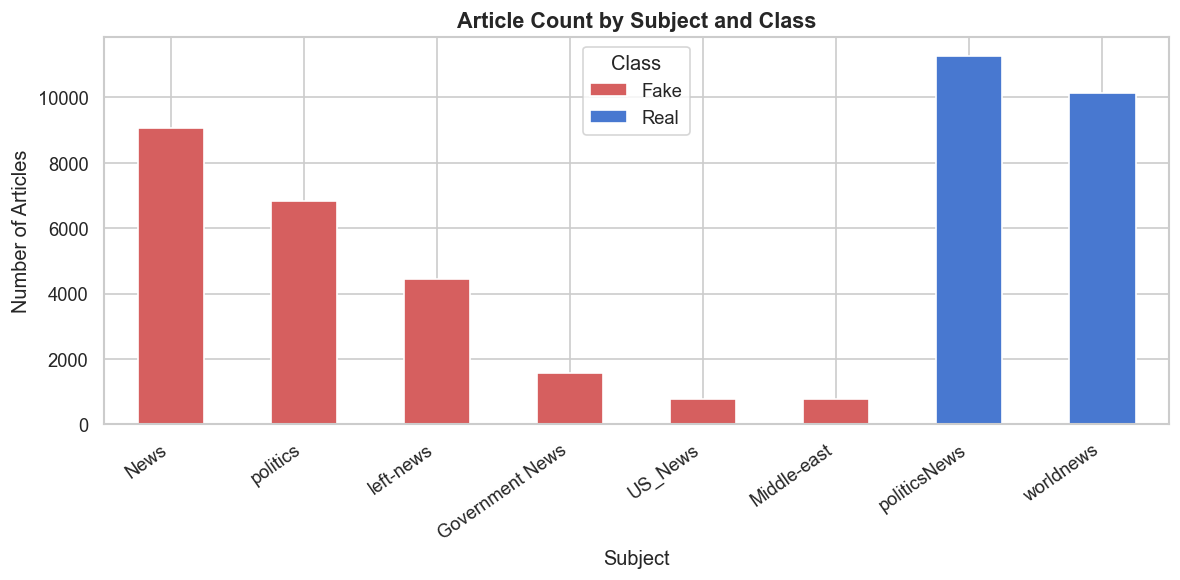

In [8]:
subject_counts = df.groupby(['subject', 'class']).size().unstack(fill_value=0)
subject_counts.columns = ['Fake', 'Real']
subject_counts = subject_counts.sort_values('Fake', ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
subject_counts.plot(
    kind='bar', stacked=True, ax=ax,
    color=[sns.color_palette('muted')[3], sns.color_palette('muted')[0]],
    edgecolor='white'
)
ax.set_title('Article Count by Subject and Class', fontsize=13, fontweight='bold')
ax.set_xlabel('Subject')
ax.set_ylabel('Number of Articles')
ax.legend(title='Class')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

### 2f. Average Article Length by Subject

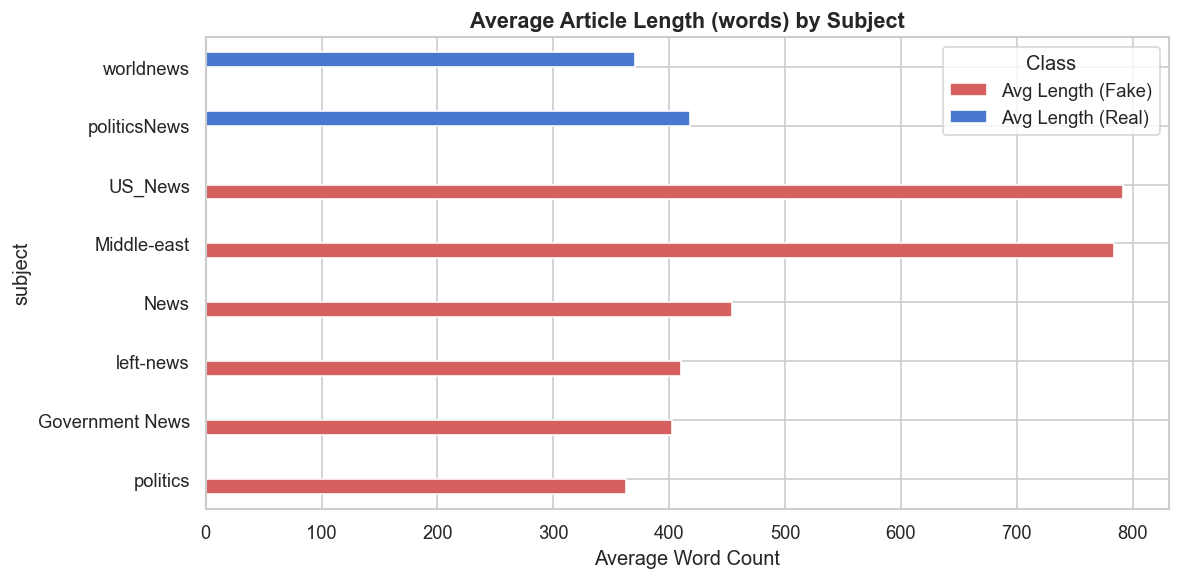

In [9]:
avg_len = df.groupby(['subject', 'class'])['word_count'].mean().unstack()
avg_len.columns = ['Avg Length (Fake)', 'Avg Length (Real)']
avg_len = avg_len.sort_values('Avg Length (Fake)', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
avg_len.plot(
    kind='barh', ax=ax,
    color=[sns.color_palette('muted')[3], sns.color_palette('muted')[0]],
    edgecolor='white'
)
ax.set_title('Average Article Length (words) by Subject', fontsize=13, fontweight='bold')
ax.set_xlabel('Average Word Count')
ax.legend(title='Class')
plt.tight_layout()
plt.show()

### EDA Summary — Key Findings

1. **Dataset is nearly balanced** — ~21k real articles and ~23k fake articles, so no heavy class-weighting is needed.
2. **Real news articles are longer on average** — the Reuters-sourced real articles tend to be structured news reports, while fake articles span a wide length range including very short and very long pieces.
3. **Subject categories are strongly segregated** — subjects like `politicsNews` and `worldNews` appear almost exclusively in real news, while `News` and `politics` (different capitalisation) are overwhelmingly fake. This means subject itself would be a near-perfect feature — but we deliberately exclude it to test models on text alone.
4. **"Reuters" is a dominant signal in real news** — the word clouds and top-word charts reveal that real news is dominated by Reuters byline language; this will be a very strong SHAP feature in the TF-IDF model (and why we strip those tags in preprocessing to avoid leakage).

---
## 3. Preprocessing Pipeline

We apply the following steps to the `title_text` column:

| Step | Why |
|---|---|
| Strip Reuters tags | Avoid leaking source identity |
| Remove URLs, hashtags, mentions | Noise reduction |
| Remove "featured image via..." | Boilerplate from fake news sites |
| Lowercase | Normalise case |
| Remove numbers & punctuation | Reduce vocabulary size |
| Tokenise (NLTK) | Split into meaningful units |
| Remove stopwords | Focus on content words |
| PorterStemmer | Conflate morphological variants |
| Rejoin | Produce `clean_text` string |

In [10]:
stemmer = PorterStemmer()

def preprocess(text: str) -> str:
    # 1. Strip Reuters source tags, e.g. "WASHINGTON (Reuters) -"
    text = re.sub(r'[A-Z\s]+\(Reuters\)\s*-\s*', '', text)
    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # 3. Remove hashtags and mentions
    text = re.sub(r'[@#]\w+', '', text)
    # 4. Remove 'featured image via ...' boilerplate
    text = re.sub(r'featured image via.*', '', text, flags=re.IGNORECASE)
    # 5. Lowercase
    text = text.lower()
    # 6. Remove digits
    text = re.sub(r'\d+', '', text)
    # 7. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 8. Tokenise
    tokens = word_tokenize(text)
    # 9. Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in STOP and len(t) > 2]
    # 10. Stem
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

# Sanity check
sample = "WASHINGTON (Reuters) - The White House said on Tuesday ..."
print('Before:', sample)
print('After :', preprocess(sample))

Before: WASHINGTON (Reuters) - The White House said on Tuesday ...
After : white hous said tuesday


In [11]:
from tqdm.notebook import tqdm
tqdm.pandas()

print('Applying preprocessing pipeline...')
df['clean_text'] = df['title_text'].progress_apply(preprocess)

# Drop rows that became empty after cleaning
empty_mask = df['clean_text'].str.strip() == ''
print(f'Empty after cleaning: {empty_mask.sum()}')
df = df[~empty_mask].reset_index(drop=True)

print(f'Final dataset size: {len(df):,}')
df[['clean_text', 'class']].head(3)

Applying preprocessing pipeline...


  0%|          | 0/44898 [00:00<?, ?it/s]

Empty after cleaning: 9
Final dataset size: 44,889


,clean_text,class
0,budget fight loom republican flip fiscal scrip...,1
1,militari accept transgend recruit monday penta...,1
2,senior republican senat let mueller jobth spec...,1


---
## 4. Save Cleaned Data

In [12]:
PROCESSED_DIR = '../data/processed'
os.makedirs(PROCESSED_DIR, exist_ok=True)

out_path = os.path.join(PROCESSED_DIR, 'cleaned_isot.csv')
df[['clean_text', 'title_text', 'class']].to_csv(out_path, index=False)
print(f'Saved {len(df):,} rows to {out_path}')

Saved 44,889 rows to ../data/processed/cleaned_isot.csv
